In [242]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import important libraries

In [108]:
!pip install dill

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import warnings
from sklearn.exceptions import FitFailedWarning
import pickle

In [110]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Read preprocessed train data

In [111]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed')['target_event']

# Read and transform test data

In [112]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as file:
    test_pipeline = dill.load(file)

In [113]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')['target_event']

# Binary evaluation class

In [114]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

In [115]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy

    def classification_report(self):
        report = classification_report(self.y_test, self.y_pred)
        return report

    def precision_recall_f1(self):
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        return precision, recall, f1
    def roc_score(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        return auc_score

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_visualization(self):
        auc_score = self.roc_score()
        print('=========================')
        print('||','ROC AUC Score:', auc_score.round(2),'||')
        print('=========================')
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_curve_plot(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

# All models' evaluation

In [116]:
Model_Evaluation = {}

---
# ***Model experiments***
---

# Logistic Regression

## Import libraries

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Initialize logistic regression

In [118]:
log_clf = LogisticRegression(max_iter=10000, n_jobs=-1)

# Determine folds for cross-validation

In [119]:
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Determine grid search and its parameters

In [120]:
log_search_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'tol': [1e-10, 1e-6],
    'C': [10, 100, 150],
}

In [121]:
log_search = GridSearchCV(log_clf,
                          log_search_params,
                          cv=folds,
                          scoring={'roc_auc': 'roc_auc', 'f1_score': 'f1'},
                          refit='roc_auc',
                          error_score=np.nan,
                          n_jobs=-1)

In [122]:
log_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=10000, n_jobs=-1), n_jobs=-1,
             param_grid={'C': [10, 100, 150],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'tol': [1e-10, 1e-06]},
             refit='roc_auc', scoring={'f1_score': 'f1', 'roc_auc': 'roc_auc'})

# Get the best parameters

In [124]:
best_model_params_log = log_search.best_params_
best_model = log_search.best_estimator_

# Evaluate the model from different corner

In [125]:
y_pred_log = best_model.predict(X_test)
y_pred_prob_log = best_model.predict_proba(X_test)[:, 1]

In [126]:
log_evaluation = BinaryClassificationEvaluation(y_test, y_pred_log, y_pred_prob_log)

In [127]:
print(log_evaluation.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     15296
           1       0.70      0.76      0.73      7226

    accuracy                           0.82     22522
   macro avg       0.79      0.81      0.80     22522
weighted avg       0.83      0.82      0.82     22522



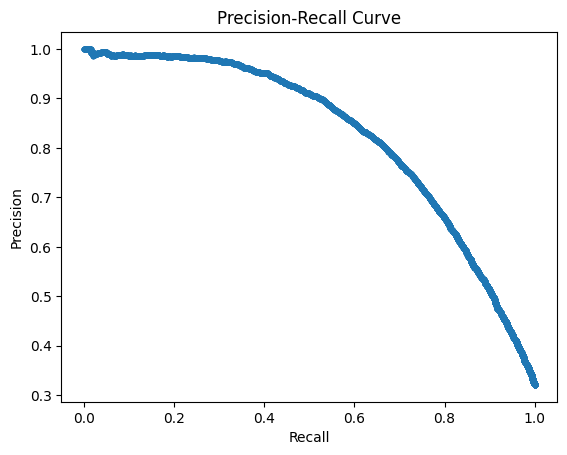

In [128]:
log_evaluation.precision_recall_curve_plot()

|| ROC AUC Score: 0.88 ||


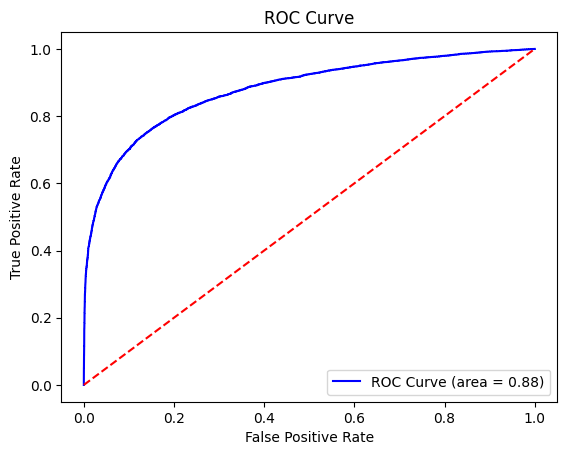

In [129]:
log_evaluation.roc_curve_visualization()

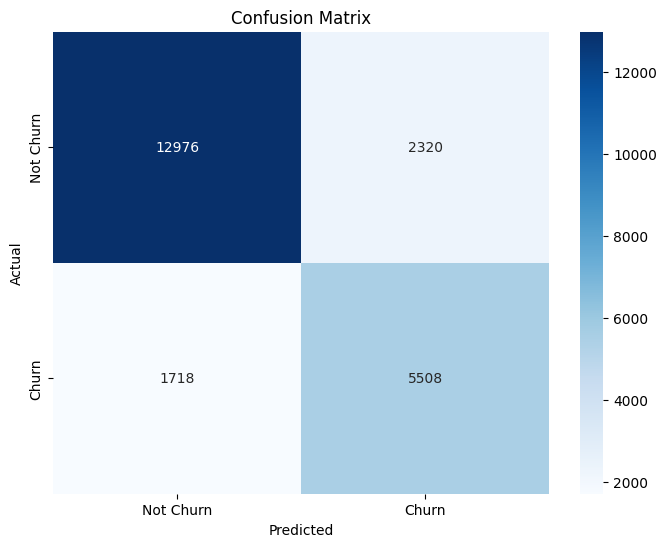

In [130]:
log_evaluation.visualize_confusion_matrix()

In [133]:
precision, recall, f1 = log_evaluation.precision_recall_f1()
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.7036280020439448
Recall: 0.7622474398007196
F1 Score: 0.7317656436827421


# Try different decision threshold to increase performance

In [138]:
decision_func_log = log_search.decision_function(X_test)

In [148]:
pd.Series(decision_func_log).describe()

,0
count,22522.000000
mean,-0.251522
std,2.035527
min,-4.366088
25%,-1.724980
50%,-0.773739
75%,0.735357
max,6.867870


In [196]:
threshold = 0.3
y_pred_thresh_log = (decision_func_log >= threshold).astype(int)

In [197]:
log_evaluation_thesh = BinaryClassificationEvaluation(y_test, y_pred_thresh_log, y_pred_prob_log)

In [198]:
precision_thesh, recall_thesh, f1_thesh = log_evaluation_thesh.precision_recall_f1()

# Choose 0.3 as decision threshold because it showed best precision/recall traid-off

In [199]:
report_thesh = log_evaluation_thesh.classification_report()
print(report_thesh)
print(f1_thesh)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     15296
           1       0.76      0.71      0.73      7226

    accuracy                           0.83     22522
   macro avg       0.81      0.80      0.81     22522
weighted avg       0.83      0.83      0.83     22522

0.7345164279096287


In [200]:
print(log_evaluation.classification_report())
print(f1)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     15296
           1       0.70      0.76      0.73      7226

    accuracy                           0.82     22522
   macro avg       0.79      0.81      0.80     22522
weighted avg       0.83      0.82      0.82     22522

0.7317656436827421


# Create custom class for logistic regression

In [234]:
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

In [255]:
class LogisticRegressionCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty='l2', tol=1e-6, C=1.0, max_iter=10000, threshold=0.3):
        self.penalty = penalty
        self.tol = tol
        self.C = C
        self.max_iter = max_iter
        self.threshold = threshold
        self.model = None

    def fit(self, X, y):
        self.model = LogisticRegression(penalty=self.penalty, tol=self.tol, C=self.C,
                                         max_iter=self.max_iter)
        self.model.fit(X, y)

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model must be fitted before making predictions.")

        decision_func = self.model.decision_function(X)
        y_pred = (decision_func >= self.threshold).astype(int)
        return y_pred

    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model must be fitted before making predictions.")
        return self.model.predict_proba(X)

    def set_threshold(self, new_threshold):
        self.threshold = new_threshold

    def get_threshold(self):
        return self.threshold

    def save_model(self, file_path):
        with open(file_path, 'wb') as file:
            dill.dump(self, file)

In [256]:
best_params = log_search.best_params_
best_index = np.argmax(log_search.cv_results_['mean_test_roc_auc'])

log_reg_thesh = LogisticRegressionCustom(
    penalty=best_params.get('penalty', 'l2'),
    tol=best_params.get('tol', 1e-6),
    C=best_params.get('C', 1.0),
    threshold=0.3
)

log_reg_thesh.fit(X_train, y_train)

In [257]:
thresh_eval = BinaryClassificationEvaluation(y_test, log_reg_thesh.predict(X_test), log_reg_thesh.predict_proba(X_test)[:, 1])

In [258]:
print(thresh_eval.classification_report())
print(thresh_eval.precision_recall_f1())
print(thresh_eval.roc_score())

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     15296
           1       0.76      0.71      0.73      7226

    accuracy                           0.83     22522
   macro avg       0.81      0.80      0.81     22522
weighted avg       0.83      0.83      0.83     22522

(0.7572373254959589, 0.7131192914475505, 0.7345164279096287)
0.8796278667254579


# Save model with all best parameters and threshold

In [259]:
log_reg_thesh.save_model('/content/drive/MyDrive/Churn Prediction/log_reg_model.pkl')

# Load the model

In [260]:
with open('/content/drive/MyDrive/Churn Prediction/log_reg_model.pkl', 'rb') as file:
    log_regression_model = dill.load(file)